# Calibration plots for the paper

How to use it :

config : dictionary that should contain : (sweep id, model class, dataset class)


In [7]:
from ms_benchmark import predict_utils, calibration_utils
from ms_benchmark.models.baseline_dynamic import models as dynamic_models
from ms_benchmark.models.baseline_dynamic import data_utils as dynamic_data_utils

from ms_benchmark.models.baseline_static import models as static_models
from ms_benchmark.models.baseline_static import data_utils as static_data_utils

from ms_benchmark.models.RNN import models as RNN_models
from ms_benchmark.models.RNN import data_utils as RNN_data_utils

from ms_benchmark.models.attention import models_new as attention_models
from ms_benchmark.models.attention import data_utils as attention_data_utils

import wandb
import pytorch_lightning as pl
import torch

import os
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd

In [4]:
config = {"Dynamic Baseline" : ("8eaupe5h",dynamic_models.PointWiseModel, dynamic_data_utils.PointWiseDataset),
         "Static Baseline" : ("wrzuwh58", static_models.PointWiseModel, static_data_utils.PointWiseDataset),
         #"RNN" : ("gfbjt65v", RNN_models.RNNModel, RNN_data_utils.LongitudinalDataset),
        "Attention" : ("a9zakq0n",attention_models.AttentionModel, attention_data_utils.LongitudinalDataset)
         }
results = {}
fold_num = 0 # fold for which to do the calibration plot

In [5]:
gpu = 1
api = wandb.Api()

for key in config.keys():
    model_cls = config[key][1]
    data_cls = config[key][2]


    sweep = api.sweep(f"ms_prognosis_2021/msbase_21/{config[key][0]}")
    
    results[key] = []
    best_runs = []
    for fold in [fold_num]:
        runs_fold = [r for r in sweep.runs if r.config.get("fold")==fold]
        runs_fold_sorted = sorted(runs_fold,key = lambda run: run.summary.get("best_val_auc"), reverse = True)
        best_runs.append(runs_fold_sorted[0])
    
    for run in best_runs:
        run_name = run.id
        print(run_name)
        model, dataset = predict_utils.load_run(run_name,model_cls,data_cls)
        trainer = pl.Trainer(logger = False, gpus=gpu)
        out = trainer.predict(model,dataset.test_dataloader())
        out_val = trainer.predict(model,dataset.val_dataloader())
        
        y_true_test = torch.cat([o["y"] for o in out]).cpu()
        y_pred_test = torch.softmax(torch.cat([o["y_pred"] for o in out]).cpu(),-1)[:,1]
        
        y_true_val = torch.cat([o["y"] for o in out_val]).cpu()
        y_pred_val = torch.softmax(torch.cat([o["y_pred"] for o in out_val]).cpu(),-1)[:,1]
        
        calibration_dict = calibration_utils.calibration(y_pred_val, y_true_val, y_pred_test, y_true_test)
        results[key].append(calibration_dict)

9b8wb769


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

a921c4h1
['MSCOURSE_AT_VISIT_PP', 'MSCOURSE_AT_VISIT_RR', 'MSCOURSE_AT_VISIT_SP', 'Education_higher', 'Education_lower', 'Education_unknown', 'gender_F', 'gender_M', 'FIRST_SYMPTOM_OPTIC_PATHWAYS_False', 'FIRST_SYMPTOM_OPTIC_PATHWAYS_True', 'FIRST_SYMPTOM_BRAINTSTEM_False', 'FIRST_SYMPTOM_BRAINTSTEM_True', 'FIRST_SYMPTOM_SPINAL_CORD_False', 'FIRST_SYMPTOM_SPINAL_CORD_True', 'FIRST_SYMPTOM_SUPRATENTORIAL_False', 'FIRST_SYMPTOM_SUPRATENTORIAL_True', 'DMT_AT_0_Mild', 'DMT_AT_0_Moderate', 'DMT_AT_0_High', 'DMT_IND_AT_0_High_Induction', 'EDSS_at_0', 'date_reference', 'onset_date_reference', 'last_KFS_1_at_0', 'last_KFS_2_at_0', 'last_KFS_3_at_0', 'last_KFS_4_at_0', 'last_KFS_5_at_0', 'last_KFS_6_at_0', 'last_KFS_7_at_0', 'last_KFS_AMBULATION_at_0', 'last_KFS_1_at_0_mask', 'last_KFS_2_at_0_mask', 'last_KFS_3_at_0_mask', 'last_KFS_4_at_0_mask', 'last_KFS_5_at_0_mask', 'last_KFS_6_at_0_mask', 'last_KFS_7_at_0_mask', 'last_KFS_AMBULATION_at_0_mask', 'disease_duration_at_0_years', 'age_at_onset_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

w70fanmn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

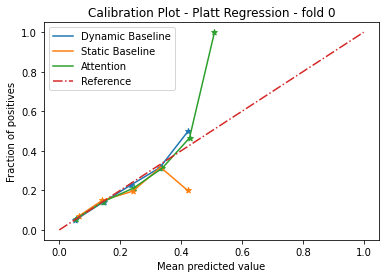

In [6]:
calibration_type = "platt" # "platt" or "iso"
name = "Platt Regression" # used in the title of the plot

fold_idx = 0
plt.figure()
for key in results.keys():
    y_true, y_pred, y_calibrated = results[key][fold_idx][calibration_type]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_calibrated, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, label = key)
    plt.scatter(mean_predicted_value, fraction_of_positives,marker = "*")
plt.plot(np.linspace(0,1),np.linspace(0,1),linestyle = "-.", label = "Reference")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title(f"Calibration Plot - {name} - fold {fold_num}")
plt.legend()
plt.savefig(f"{calibration_type}_fold{fold_num}.pdf")
plt.show()

# Saving the model predictions for more detailed calibration plot

In [31]:
for key in results.keys():
    y_true, y_pred, y_calibrated = results[key][fold_num][calibration_type]
    pd.DataFrame(y_pred).to_csv(f"./results/y_pred_{key}.csv",index = False)
    pd.DataFrame(y_true).to_csv(f"./results/y_true_{key}.csv",index = False)
    pd.DataFrame(y_calibrated).to_csv(f"./results/y_calibrated_{key}.csv",index = False)

In [28]:
results.keys()

dict_keys(['Dynamic Baseline', 'Static Baseline', 'RNN', 'Attention'])

# With pre-loaded predictions

In [14]:
config = [
    "Dynamic Baseline",
    "Static Baseline",
    "Bayesian NN",
    #"RNN",
    "Attention",
]

results = {}
for key in config:
    metrics = {"ROC-AUC":[],"AUC-PR":[],"Brier":[],"ECE":[]}
    results[key] = {fold : None for i in range(5)}
    for fold in range(5):
        
        one_word_name = "_".join(key.split(" "))
        directory  = f"../Evaluation/preds_vectors/{one_word_name}/fold_{fold}/"
        df_test = pd.read_csv(directory + "df_test.csv")
        y_true = torch.load(directory + "y_true.pt")
        y_calibrated = torch.load(directory + "y_calibrated.pt")
        
        results[key][fold] = {"platt": (y_true, None, y_calibrated)}

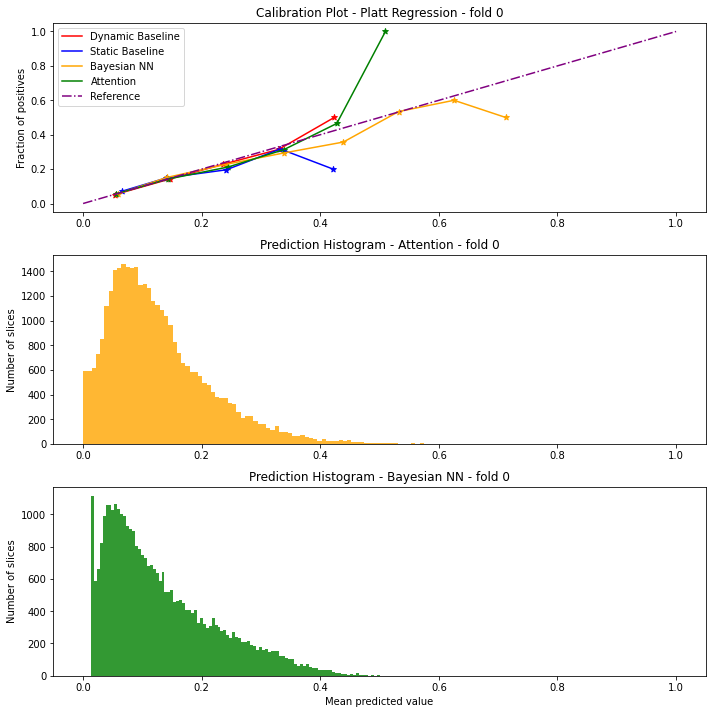

In [57]:
fold_idx = 0
colors = ["red","blue","orange","green"]
hist_names = ["Attention","Bayesian NN"]
fig, ax = plt.subplots(3, sharex=True, figsize = (10,10))
hist_count = 0
for i, key in enumerate(results.keys()):
    y_true, y_pred, y_calibrated = results[key][fold_idx][calibration_type]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_calibrated, n_bins=10)
    if key in hist_names:
        ax[hist_count+1].hist(y_calibrated,bins=100, color = colors[i],alpha = 0.8, label = key)
        hist_count += 1
    ax[0].plot(mean_predicted_value, fraction_of_positives, label = key, color = colors[i])
    ax[0].scatter(mean_predicted_value, fraction_of_positives,marker = "*", color = colors[i])
ax[0].plot(np.linspace(0,1),np.linspace(0,1),linestyle = "-.", label = "Reference", color = "purple")
ax[0].set_ylabel("Fraction of positives")
ax[1].set_ylabel("Number of slices")
ax[2].set_ylabel("Number of slices")
ax[2].set_xlabel("Mean predicted value")
ax[0].set_title(f"Calibration Plot - {name} - fold {fold_num}")
ax[1].set_title(f"Prediction Histogram - {hist_names[0]} - fold {fold_num}")
ax[2].set_title(f"Prediction Histogram - {hist_names[1]} - fold {fold_num}")
ax[0].tick_params('x',labelbottom=True)
ax[1].tick_params('x',labelbottom=True)

ax[0].legend()


fig.savefig(f"{calibration_type}_fold{fold_num}.pdf")
fig.tight_layout()

In [56]:
for key in results.keys():
    y_true, y_pred, y_calibrated = results[key][fold_num][calibration_type]
    pd.DataFrame(y_pred).to_csv(f"./results/y_pred_{key}.csv",index = False)
    pd.DataFrame(y_true).to_csv(f"./results/y_true_{key}.csv",index = False)
    pd.DataFrame(y_calibrated).to_csv(f"./results/y_calibrated_{key}.csv",index = False)